In [1]:
#Link to the Paper the Parameters were obtained from:
#https://www.tandfonline.com/doi/full/10.1080/00295450.2021.1906474
!rm *.xml
!rm *.png
!rm *.h5

rm: cannot remove '*.png': No such file or directory


In [2]:
import openmc
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Parameters [cm]
monolith_pitch = 2.15
fuel_radius = 0.975
moderator_radius = 1
heat_pipe_radius = 1
height = 60
flat_to_flat = 32.153

#Materials
#Fuel: Uranium Nitride (UN)
un = openmc.Material()
un.add_element('N', 1.0)
un.add_nuclide('U235', .1605, 'ao')
un.add_nuclide('U238', 1-.1605, 'ao')
un.set_density('g/cm3', 14.3)

#Moderator: Yttrium Hydride (YH2)
yh2 = openmc.Material()
yh2.add_element('Y', 1.0)
yh2.add_element('H', 2.0)
yh2.set_density('g/cm3', 4.3)

#Monolith: Stainless Steel 316 (various elements)
ss316 = openmc.Material()
ss316.add_element('Fe', 65.9, 'wo')
ss316.add_element('Cr', 17.0, 'wo')
ss316.add_element('Ni', 12.01, 'wo')
ss316.add_element('Mo', 2.0, 'wo')
ss316.add_element('Mn', 2.0, 'wo')
ss316.add_element('Si', 1.0, 'wo')
ss316.add_element('P', 0.04, 'wo')
ss316.add_element('S', 0.03, 'wo')
ss316.add_element('C', 0.02, 'wo') #Carbon is C0 when displayed
ss316.set_density('g/cm3', 7.9)

#Heat Pipe: Approxmated as Copper (Cu)
cu = openmc.Material()
cu.add_element('Cu', 1.0)
cu.set_density('g/cm3', 8.92)

#Materials xml
materials = openmc.Materials((un, yh2, ss316, cu))
materials.export_to_xml()

In [3]:
#Universes for each cell type
r_fuel = openmc.ZCylinder(r=fuel_radius)
fuel_cell = openmc.Cell(fill=un, region=-r_fuel)
monolith_cell = openmc.Cell(fill=ss316, region=+r_fuel)
fuel_universe = openmc.Universe(cells=(fuel_cell, monolith_cell))

r_mod = openmc.ZCylinder(r=moderator_radius)
mod_cell = openmc.Cell(fill=yh2, region=-r_mod)
monolith2_cell = openmc.Cell(fill=ss316, region=+r_mod)
mod_universe = openmc.Universe(cells=(mod_cell, monolith2_cell))

r_hp = openmc.ZCylinder(r=heat_pipe_radius)
hp_cell = openmc.Cell(fill=cu, region=-r_hp)
monolith3_cell = openmc.Cell(fill=ss316, region=+r_hp)
hp_universe = openmc.Universe(cells=(hp_cell, monolith3_cell))

all_ss316_cell = openmc.Cell(fill=ss316)
outer_universe = openmc.Universe(cells=(all_ss316_cell,))

In [4]:
#Lattice
lattice = openmc.HexLattice()

lattice.orientation = 'x'
lattice.center = (0,0)
lattice.pitch = (monolith_pitch,)
lattice.outer = outer_universe

#print(lattice.show_indices(num_rings=9))

In [5]:
#Ring Universes
layer0 = ([hp_universe] + [fuel_universe])*24
layer1 = [mod_universe]*42
layer2 = ([hp_universe] + [fuel_universe])*18
layer3 = [mod_universe]*30
layer4 = ([hp_universe] + [fuel_universe])*12
layer5 = [mod_universe]*18
layer6 = ([hp_universe] + [fuel_universe])*6
layer7 = [mod_universe]*6
layer8 = [hp_universe]

lattice.universes = [layer0,layer1,layer2,layer3,layer4,layer5,layer6,layer7,layer8]
#print(lattice)

In [6]:
#Outer surface
outer_surface = openmc.model.HexagonalPrism(
    edge_length=flat_to_flat/(3)**(.5),
    orientation='x',
    boundary_type='reflective'
)

top = openmc.ZPlane(z0=height/2, boundary_type='vacuum')
bot = openmc.ZPlane(z0=-height/2, boundary_type='vacuum')
layer = -top & +bot

main_cell = openmc.Cell(fill=lattice, region=(-outer_surface & layer))

geometry = openmc.Geometry([main_cell])
geometry.export_to_xml()

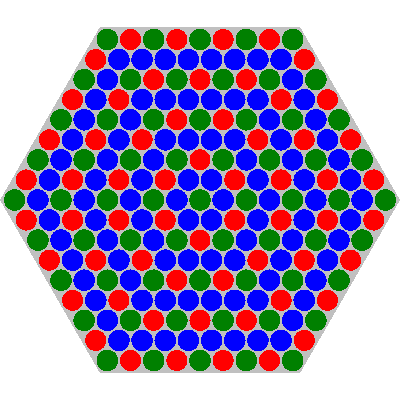

In [8]:
#Plotting
width = 2*flat_to_flat/(3)**(.5)

plot = openmc.Plot()
plot.color_by = 'material'
plot.origin = (0,0,0)
plot.width = (width,width)
plot.geometry = geometry
plot.colors = {
    un: 'red',
    yh2: 'blue',
    cu: 'green',
    ss316: 'silver'
}

plot.to_ipython_image()

In [8]:
#Model Settings
#model = openmc.Model()

point = openmc.stats.Point((0,0,0))
src = openmc.IndependentSource(space=point)

settings = openmc.Settings()
settings.source = src
settings.particles = 1000
settings.batches = 100
settings.inactive = 50
settings.export_to_xml()

In [22]:
#Tally
tallies = openmc.Tallies()

mesh_len = 1000
mesh_dimensions = (mesh_len,mesh_len)

#Mesh
mesh = openmc.RegularMesh()
mesh.lower_left = (-width/2, -width/2)
mesh.upper_right = (width/2, width/2)
mesh.dimension = mesh_dimensions
mesh_filter = openmc.MeshFilter(mesh)

#Different Tallies
heat = openmc.Tally()
heat.scores = ['kappa-fission']
heat.filters = [mesh_filter]

flux = openmc.Tally()
flux.scores = ['flux']
flux.filters = [mesh_filter]

#Tally XML
tallies.append(heat)
tallies.append(flux)
tallies.export_to_xml()

In [11]:
openmc.run(output=False)

In [21]:
#Getting the statepoint
sp = openmc.StatePoint('statepoint.100.h5')
tally = sp.get_tally()
print(tally)

Tally
	ID             =	1
	Name           =	
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True


In [12]:
#Tally commands
#(tally.sum, tally.mean.shape)
#(tally.mean, tally.std_dev)

In [15]:
#Getting the heat
heat_scores = sp.get_tally(scores=['kappa-fission'])
flux_scores = sp.get_tally(scores=['flux'])

print(heat_scores)
print(flux_scores)

#Reshaping
heat_scores.std_dev.shape = mesh_dimensions
heat_scores.mean.shape = mesh_dimensions

flux_scores.std_dev.shape = mesh_dimensions
flux_scores.mean.shape = mesh_dimensions

Tally
	ID             =	1
	Name           =	
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['kappa-fission']
	Estimator      =	tracklength
	Multiply dens. =	True
Tally
	ID             =	2
	Name           =	
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength
	Multiply dens. =	True


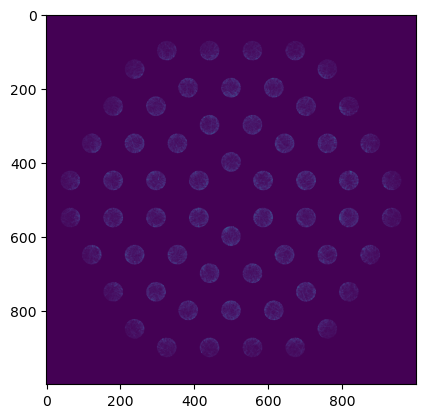

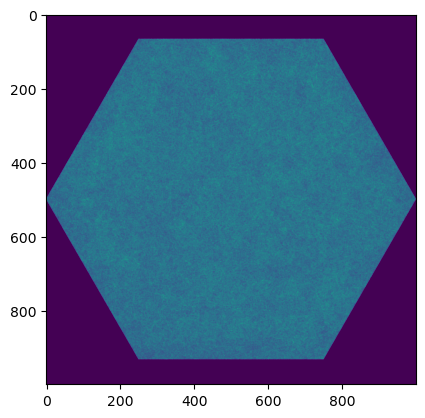

In [18]:
#Plotting
fig1 = plt.subplot()
fig1.imshow(heat_scores.mean)
plt.show()

fig2 = plt.subplot()
fig2.imshow(flux_scores.mean)
plt.show()